## Applicazione analisi Detection Histories e Modelli Occupancy

### Claudia Gabriela Ochoa Martinez (2020)

In [1]:
#### Inserire l'anno su cui si vuole effettuare l'analisi es. =="2014", "2015", ecc
anno_analisi <- "2015"
sessione_analisi <- "1"

In [2]:
library(dplyr)
library(readr)
library(unmarked)
require(stats4)
require(parallel)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: stats4


Attaching package: 'stats4'


The following object is masked from 'package:unmarked':

    mle


Loading required package: parallel



In [3]:
# Matrice di detection history (catture effettive) -- y
catture_effettive <- read.csv("Dati-preparazione-modello\\catture_effettive_totale.csv", dec=",", sep=";", header = TRUE)

# Leggiamo le matrici dell'Orario (Alba Tramonto), Precipitazioni e Temperatura -- ObsCovs
orario_occasione <- read.csv("Dati-preparazione-modello\\orario_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
precipitazioni_occasione <- read.csv("Dati-preparazione-modello\\precipitazioni_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
temperatura_occasione <- read.csv("Dati-preparazione-modello\\temperatura_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
velvento_occasione <- read.csv("Dati-preparazione-modello\\velvento_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

# Prendiamo Datioccas per legare l'anno alle varie osservazioni
Datioccas <- read.csv("Dati-elaborati/Dati-occasioni.csv", dec=",", sep=";", header = TRUE)

# Leggiamo il file relativo alle invarianti ambientali (covariate) -- siteCovs
siteCovs <- read.csv("Dati-preparazione-modello/Dati-cov-mdr-iqr.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

In [4]:
# Non avendo sufficienti dati sulle ultime 5 trappole, le escludiamo
catture_effettive <- catture_effettive[1:70,]

orario_occasione <- orario_occasione[1:70,]
precipitazioni_occasione <- precipitazioni_occasione[1:70,]
temperatura_occasione <- temperatura_occasione[1:70,]
velvento_occasione <- velvento_occasione[1:70,]
siteCovs <- siteCovs[1:70,]

In [5]:
# TRASFORMIAMO le specie vegetali presenti in siteCovs in numeric per evitare singolarità nei modelli
siteCovs$dominant[siteCovs$dominant != "Graminacee" & siteCovs$dominant != "Muschio"]  <- 30
siteCovs$dominant[siteCovs$dominant == "Graminacee"]  <- 20
siteCovs$dominant[siteCovs$dominant == "Muschio"]  <- 10
siteCovs$dominant <- as.numeric(siteCovs$dominant)

# Seleziono la coperatura vegetale di interesse
if (anno_analisi %in% c("2014","2015","2016","2017")) {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2015_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))
} else {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2018_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))

}
    
tail(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
65,292,99,67,2787.358,13,7,2,10,99,112.5,13,0.4
66,139,75,21,2788.498,11,29,14,30,75,59.0,11,1.2
67,77,83,40,2792.428,19,38,13,20,77,21.5,19,0.8
68,71,127,58,2794.777,13,17,10,30,71,34.5,13,1.2
69,97,75,66,2792.266,12,11,8,20,75,15.5,12,0.4
70,207,73,96,2792.857,358,2,2,30,96,67.0,-2,0.0


In [6]:
# Ricaviamo le colonne oggetto di analisi
if (exists("sessione_analisi")) {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi & sessione == sessione_analisi))
} else {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi))
}
colonne_oggetto_analisi <- as.numeric(colonne_oggetto_analisi)

In [7]:
catture_effettive_selezionate <- catture_effettive[,colonne_oggetto_analisi]

In [8]:
summary(siteCovs)

 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   : 30.00         Min.   : 28.00         Min.   :  8.00        
 1st Qu.: 67.25         1st Qu.: 44.00         1st Qu.: 40.00        
 Median : 97.00         Median : 62.00         Median : 56.50        
 Mean   :118.70         Mean   : 75.06         Mean   : 69.66        
 3rd Qu.:139.75         3rd Qu.: 92.50         3rd Qu.: 75.50        
 Max.   :440.00         Max.   :308.00         Max.   :292.00        
     alt_m        aspect_deg      slope_degr      n_species        dominant    
 Min.   :2778   Min.   :  0.0   Min.   : 0.00   Min.   : 0.00   Min.   :10.00  
 1st Qu.:2783   1st Qu.: 59.0   1st Qu.: 7.25   1st Qu.:10.25   1st Qu.:20.00  
 Median :2789   Median :314.5   Median :11.50   Median :15.00   Median :20.00  
 Mean   :2789   Mean   :239.4   Mean   :13.04   Mean   :15.59   Mean   :20.14  
 3rd Qu.:2795   3rd Qu.:332.0   3rd Qu.:19.75   3rd Qu.:21.00   3rd Qu.:20.00  
 Max.   :2804   Max.   :358.0 

#### Concludiamo che tutte le variabili presenti in siteCovs sono adatte ad essere utilizzate nell'analisi
#### Provvediamo a scalarle e centrarle

In [9]:
siteCovs <- data.frame(scale(siteCovs))
tail(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
65,2.3221655,0.508714136,-0.05028955,-0.2773832,-1.6601337,-0.6973735,-1.7814483,-1.51357553,0.75023962,1.7135977,0.9721058,-1.0195015
66,0.2720136,-0.001214115,-0.92089358,-0.1254769,-1.6747964,1.8415278,-0.2079293,1.47093960,0.02587033,0.2800171,0.9178632,-0.5418234
67,-0.5587669,0.168761969,-0.56129626,0.3982001,-1.6161456,2.8801692,-0.3390559,-0.02131797,0.08623444,-0.7248291,1.1348338,-0.7806624
68,-0.6391650,1.103630428,-0.22062512,0.7112070,-1.6601337,0.4566725,-0.7324356,1.47093960,-0.09485788,-0.3764824,0.9721058,-0.5418234
69,-0.2907732,-0.001214115,-0.06921572,0.3766134,-1.6674651,-0.2357551,-0.9946888,-0.02131797,0.02587033,-0.8856045,0.9449845,-1.0195015
70,1.1831922,-0.043708136,0.49856951,0.4553648,0.8691849,-1.2743966,-1.7814483,1.47093960,0.65969346,0.4943843,0.5652859,-1.2583405


In [10]:
summary(t(orario_occasione[1,colonne_oggetto_analisi]))
summary(t(precipitazioni_occasione[1,colonne_oggetto_analisi]))
summary(t(temperatura_occasione[1,colonne_oggetto_analisi]))
summary(t(velvento_occasione[1,colonne_oggetto_analisi]))


  1     
 Al:11  
 Tr:11  

       1         
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.1727  
 3rd Qu.:0.0000  
 Max.   :3.0000  

       1        
 Min.   :11.00  
 1st Qu.:14.28  
 Median :15.60  
 Mean   :15.55  
 3rd Qu.:17.23  
 Max.   :18.90  

       1        
 Min.   :0.400  
 1st Qu.:0.900  
 Median :1.250  
 Mean   :1.514  
 3rd Qu.:2.050  
 Max.   :4.200  

#### La variabile relativa alle precipitazioni, nel 2015, è inadatta alle analisi, verrà automaticamente scartata dal modello
#### Le variabili categoriche non possono essere scalate (orario_ooccasione)
#### La variabile temperatura_occasione è inadatta ad essere scalata

In [11]:
obsCovs <- list(
    orario = orario_occasione[,colonne_oggetto_analisi],
    precip = precipitazioni_occasione[,colonne_oggetto_analisi],
    temper = temperatura_occasione[,colonne_oggetto_analisi],
    vento = velvento_occasione[,colonne_oggetto_analisi]

)


In [12]:
arvicole <- unmarkedFrameOccu(y = catture_effettive_selezionate, siteCovs = siteCovs, obsCovs = obsCovs)
summary(arvicole)

unmarkedFrame Object

70 sites
Maximum number of observations per site: 22 
Mean number of observations per site: 22 
Sites with at least one detection: 30 

Tabulation of y observations:
   0    1 
1494   46 

Site-level covariates:
 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   :-1.1886        Min.   :-0.9998        Min.   :-1.1669       
 1st Qu.:-0.6894        1st Qu.:-0.6599        1st Qu.:-0.5613       
 Median :-0.2908        Median :-0.2774        Median :-0.2490       
 Mean   : 0.0000        Mean   : 0.0000        Mean   : 0.0000       
 3rd Qu.: 0.2821        3rd Qu.: 0.3706        3rd Qu.: 0.1106       
 Max.   : 4.3053        Max.   : 4.9493        Max.   : 4.2081       
     alt_m            aspect_deg        slope_degr        n_species      
 Min.   :-1.53434   Min.   :-1.7554   Min.   :-1.5052   Min.   :-2.0437  
 1st Qu.:-0.91819   1st Qu.:-1.3229   1st Qu.:-0.6685   1st Qu.:-0.6997  
 Median :-0.08237   Median : 0.5503   Median :-0.1781 

In [14]:
#    occu(~P            # PROBABILITA' DI AVVISTAMENTO
#         ~PSI,         # EFFETTIVA PRESENZA
#          dataset)
fm.base <- occu(~orario + temper + MDR + vento
            ~slope_degr + I(slope_degr^2) +
            MDR + I(MDR^2) +
            IQR + I(IQR^2) +
            Esp.tr + I(Esp.tr^2)+
            cop_veg_ottavi +
            alt_m + I(alt_m^2) +
            n_species + I(n_species^2) +
            dominant,
            arvicole)
fm.base


Warning message in sqrt(diag(vcov(obj))):
"Si è prodotto un NaN"



Call:
occu(formula = ~orario + temper + MDR + vento ~ slope_degr + 
    I(slope_degr^2) + MDR + I(MDR^2) + IQR + I(IQR^2) + Esp.tr + 
    I(Esp.tr^2) + cop_veg_ottavi + alt_m + I(alt_m^2) + n_species + 
    I(n_species^2) + dominant, data = arvicole)

Occupancy:
                Estimate   SE        z P(>|z|)
(Intercept)        -33.4 2803 -0.01194   0.990
slope_degr          98.1 4921  0.01994   0.984
I(slope_degr^2)    128.1 2634  0.04862   0.961
MDR                -46.0 6914 -0.00665   0.995
I(MDR^2)           -13.0  NaN      NaN     NaN
IQR                -45.7 4650 -0.00983   0.992
I(IQR^2)           106.1 5138  0.02065   0.984
Esp.tr             -23.3 5229 -0.00445   0.996
I(Esp.tr^2)        -17.2 2636 -0.00651   0.995
cop_veg_ottavi      35.8 4231  0.00846   0.993
alt_m               22.1 5082  0.00435   0.997
I(alt_m^2)          10.5 3124  0.00335   0.997
n_species          -81.9  NaN      NaN     NaN
I(n_species^2)     -65.8 2651 -0.02484   0.980
dominant           -88.6 3685 -

In [14]:
#fm.base <- occu(~orario+temper 
#            ~Diametro.roccia.1..cm.+
 #           Diametro.roccia.2..cm.+
  #          Diametro.roccia.3..cm.+
   #         cop_veg_ottavi +
    #        slope_degr + I(slope_degr^2) +
     #       n_species + I(n_species^2) +
      #      dominant,
       #     arvicole)
#fm.base

In [15]:
######### INFORMATICA
clusterType <- if(length(find.package("snow", quiet = TRUE))) "SOCK" else "PSOCK"
clusterType
clust <- try(makeCluster(getOption("cl.cores", 4), type = clusterType))
clusterEvalQ(clust, library(unmarked))
clusterEvalQ(clust,library(MuMIn))
clusterExport(clust, "arvicole")
invisible(clusterCall(clust, "library", "stats4", character.only = TRUE))
library(MuMIn)
getAllTerms(fm.base)

[1] "SOCK"

[[1]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

[[1]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

[1] "p(MDR)"               "p(orario)"            "p(temper)"           
 [4] "p(vento)"             "psi(alt_m)"           "psi(I(alt_m^2))"     
 [7] "psi(cop_veg_ottavi)"  "psi(dominant)"        "psi(Esp.tr)"         
[10] "psi(I(Esp.tr^2))"     "psi(IQR)"             "psi(I(IQR^2))"       
[13] "psi(MDR)"             "psi(I(MDR^2))"        "psi(n_species)"      
[16] "psi(I(n_species^2))"  "psi(slope_degr)"      "psi(I(slope_degr^2))"
attr(,"intercept")
  p psi 
  1   1 
attr(,"interceptLabel")
[1] "p(Int)"   "psi(Int)"
attr(,"deps")
                     p(MDR) p(orario) p(temper) p(vento) psi(alt_m)
p(MDR)                   NA     FALSE     FALSE    FALSE      FALSE
p(orario)             FALSE        NA     FALSE    FALSE      FALSE
p(temper)             FALSE     FALSE        NA    FALSE      FALSE
p(vento)              FALSE     FALSE     FALSE       NA      FALSE
psi(alt_m)            FALSE     FALSE     FALSE    FALSE         NA
psi(I(alt_m^2))       FALSE     FALSE     FALSE    FALSE      FALSE
psi(cop_veg_ottavi)   FALSE     FALSE     FALSE    FALSE      FALSE
psi(dominant)         FALSE     FALSE     FALSE    FALSE      FALSE
psi(Esp.tr)           FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(Esp.tr^2))      FALSE     FALSE     FALSE    FALSE      FALSE
psi(IQR)              FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(IQR^2))         FALSE     FALSE     FALSE    FALSE      FALSE
psi(MDR)              FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(MDR^2))         FALSE     FALSE     FALSE    FALSE      FALSE
psi(n_species)        FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(n_species^2))   FALSE     FALSE     FALSE    FALSE      FALSE
psi(slope_degr)       FALSE     FALSE     FALSE    FALSE      FALSE
psi(I(slope_degr^2))  FALSE     FALSE     FALSE    FALSE      FALSE
                     psi(I(alt_m^2)) psi(cop_veg_ottavi) psi(dominant)
p(MDR)                         FALSE               FALSE         FALSE
p(orario)                      FALSE               FALSE         FALSE
p(temper)                      FALSE               FALSE         FALSE
p(vento)                       FALSE               FALSE         FALSE
psi(alt_m)                     FALSE               FALSE         FALSE
psi(I(alt_m^2))                   NA               FALSE         FALSE
psi(cop_veg_ottavi)            FALSE                  NA         FALSE
psi(dominant)                  FALSE               FALSE            NA
psi(Esp.tr)                    FALSE               FALSE         FALSE
psi(I(Esp.tr^2))               FALSE               FALSE         FALSE
psi(IQR)                       FALSE               FALSE         FALSE
psi(I(IQR^2))                  FALSE               FALSE         FALSE
psi(MDR)                       FALSE               FALSE         FALSE
psi(I(MDR^2))                  FALSE               FALSE         FALSE
psi(n_species)                 FALSE               FALSE         FALSE
psi(I(n_species^2))            FALSE               FALSE         FALSE
psi(slope_degr)                FALSE               FALSE         FALSE
psi(I(slope_degr^2))           FALSE               FALSE         FALSE
                     psi(Esp.tr) psi(I(Esp.tr^2)) psi(IQR) psi(I(IQR^2))
p(MDR)                     FALSE            FALSE    FALSE         FALSE
p(orario)                  FALSE            FALSE    FALSE         FALSE
p(temper)                  FALSE            FALSE    FALSE         FALSE
p(vento)                   FALSE            FALSE    FALSE         FALSE
psi(alt_m)                 FALSE            FALSE    FALSE         FALSE
psi(I(alt_m^2))            FALSE            FALSE    FALSE         FALSE
psi(cop_veg_ottavi)        FALSE            FALSE    FALSE         FALSE
psi(dominant)              FALSE            FALSE    FALSE         FALSE
psi(Esp.tr)                   NA            FALSE    FALSE         FALSE
psi(I(Esp.tr^2))           FALSE               NA    FALSE         FALSE
psi(IQR)    

In [21]:
pdd2 <- pdredge(fm.base, clust,
                subset = (`psi(alt_m)` | !`psi(I(alt_m^2))`) &&
                (`psi(alt_m)` | !`psi(I(alt_m^2))`) &&
                `psi(cop_veg_ottavi)` &&
                `psi(dominant)` &&
                (`psi(Esp.tr)` | ! `psi(I(Esp.tr^2))`) &&
                (`psi(IQR)` | ! `psi(I(IQR^2))`) &&
                (`psi(MDR)` | ! `psi(I(MDR^2))`) &&
                (`psi(n_species)` | ! `psi(I(n_species^2))`) &&
                (`psi(slope_degr)` | !`psi(I(slope_degr^2))`) &&
                `p(MDR)` &&
                `p(orario)` &&
                `p(temper)` &&
                `p(vento)`,    
                trace = 2, m.lim = c(1,NA))

Fixed terms are "p(Int)" and "psi(Int)"



  |======================                                                |  32%

ERROR: Error in checkForRemoteErrors(val): one node produced an error: il sistema è numericamente singolare: valore di condizione di reciprocità = 2.1067e-16


In [17]:
#save(pdd2, file="Dati-elaborati/pdd2.RData", compress=FALSE)
#load("Dati-elaborati/pdd2.RData")

In [22]:
pdd3 <- pdredge(fm.base, clust,
                subset = (`psi(slope_degr)` | !`psi(I(slope_degr^2))`) &&
                (`psi(n_species)` | ! `psi(I(n_species^2))`) &&
                (`psi(MDR)` | ! `psi(I(MDR^2))`)&&
                (`psi(IQR)` | ! `psi(I(IQR^2))`)&&
                (`psi(Esp.tr)` | ! `psi(I(Esp.tr^2))`)&&
                 `psi(cop_veg_ottavi)` &&
                # `p(MDR)` &&
                 `p(temper)` &&
                 `p(orario)` &&
                 `psi(dominant)`,
                trace = 2, m.lim = c(1,NA), rank = "AIC")
save(pdd3, file="Dati-elaborati/pdd3.RData", compress=FALSE)
load("Dati-elaborati/pdd3.RData")

Fixed terms are "p(Int)" and "psi(Int)"



  |======================                                                |  32%

ERROR: Error in checkForRemoteErrors(val): one node produced an error: il sistema è numericamente singolare: valore di condizione di reciprocità = 2.1067e-16


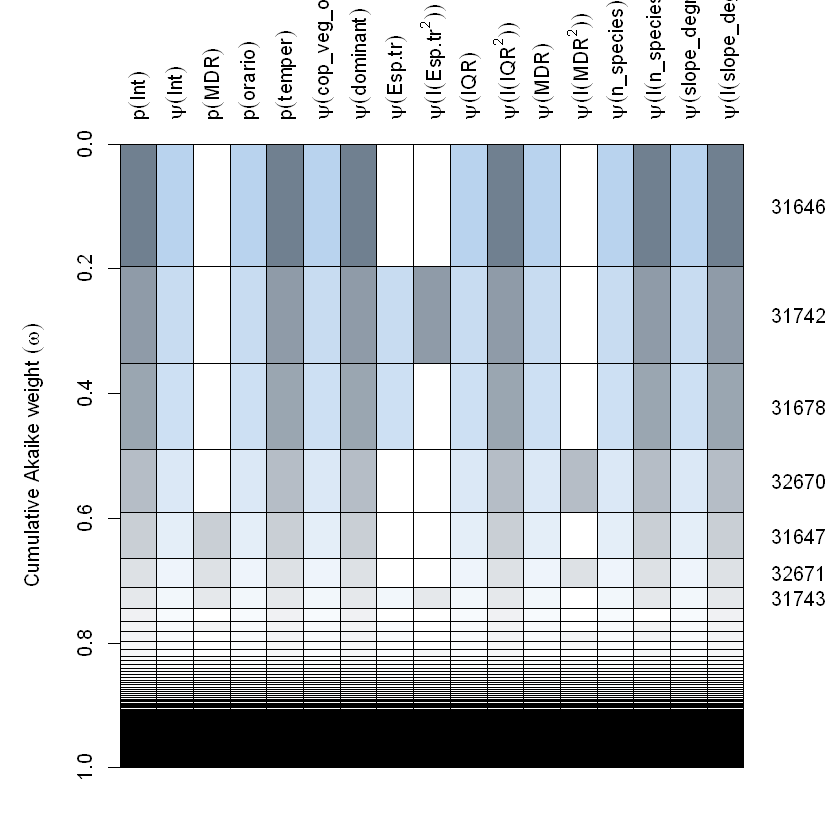

In [19]:
par(mfrow = c(1,1))
op <- par(mar = c(3,5,6,4), mfrow=c(1,1))
plot(pdd3, labAsExpr = TRUE)
par(op)


In [35]:
# riportare la tabella dei coefficienti
get.models(pdd3, 1)

$`31646`

Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + I(IQR^2) + MDR + n_species + I(n_species^2) + slope_degr + 
    I(slope_degr^2) + 1, data = arvicole)

Occupancy:
                Estimate   SE      z P(>|z|)
(Intercept)        -4.42 19.7 -0.224   0.823
cop_veg_ottavi     27.80 21.7  1.279   0.201
dominant          -43.95 31.7 -1.386   0.166
IQR               -10.81 10.9 -0.993   0.321
I(IQR^2)           34.08 21.8  1.564   0.118
MDR               -36.93 23.2 -1.595   0.111
n_species         -25.13 17.7 -1.416   0.157
I(n_species^2)    -39.22 28.4 -1.380   0.168
slope_degr         88.82 62.7  1.416   0.157
I(slope_degr^2)    89.65 58.3  1.539   0.124

Detection:
            Estimate     SE     z  P(>|z|)
(Intercept)   -5.610 1.6725 -3.35 0.000796
orarioTr       1.466 0.3878  3.78 0.000157
temper         0.112 0.0988  1.13 0.258854

AIC: 373.0054 

attr(,"rank")
function (x) 
do.call("rank", list(x))
<environment: 0x000000002989b248>
attr(,"cal

In [21]:
## PASSAGGIO DI MODEL AVERAGING: CONSIDERIAMO CONTEMPORANEAMENTE I MODELLI MIGLIORI CHE DIFFERISCONO TRA LORO
## DI POCO IN TERMINI DI AIC (deltaAIC < 2)
summary(model.avg(pdd3, subset = delta < 2))


Call:
model.avg(object = pdd3, subset = delta < 2)

Component model call: 
occu(formula = ~<5 unique rhs>, data = arvicole)

Component models: 
                               df  logLik    AIC delta weight
2/3/4/5/8/9/10/12/13/14/15     13 -173.50 373.01  0.00   0.30
2/3/4/5/6/7/8/9/10/12/13/14/15 15 -171.75 373.49  0.49   0.23
2/3/4/5/6/8/9/10/12/13/14/15   14 -172.86 373.72  0.71   0.21
2/3/4/5/8/9/10/11/12/13/14/15  14 -173.17 374.34  1.34   0.15
1/2/3/4/5/8/9/10/12/13/14/15   14 -173.48 374.96  1.96   0.11

Term codes: 
              p(MDR)            p(orario)            p(temper) 
                   1                    2                    3 
 psi(cop_veg_ottavi)        psi(dominant)          psi(Esp.tr) 
                   4                    5                    6 
    psi(I(Esp.tr^2))             psi(IQR)        psi(I(IQR^2)) 
                   7                    8                    9 
            psi(MDR)        psi(I(MDR^2))       psi(n_species) 
                  10 

In [22]:
best.mod1 <- (get.models(pdd3, 1)[[1]])
best.mod1


Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + I(IQR^2) + MDR + n_species + I(n_species^2) + slope_degr + 
    I(slope_degr^2) + 1, data = arvicole)

Occupancy:
                Estimate   SE      z P(>|z|)
(Intercept)        -4.42 19.7 -0.224   0.823
cop_veg_ottavi     27.80 21.7  1.279   0.201
dominant          -43.95 31.7 -1.386   0.166
IQR               -10.81 10.9 -0.993   0.321
I(IQR^2)           34.08 21.8  1.564   0.118
MDR               -36.93 23.2 -1.595   0.111
n_species         -25.13 17.7 -1.416   0.157
I(n_species^2)    -39.22 28.4 -1.380   0.168
slope_degr         88.82 62.7  1.416   0.157
I(slope_degr^2)    89.65 58.3  1.539   0.124

Detection:
            Estimate     SE     z  P(>|z|)
(Intercept)   -5.610 1.6725 -3.35 0.000796
orarioTr       1.466 0.3878  3.78 0.000157
temper         0.112 0.0988  1.13 0.258854

AIC: 373.0054 

In [23]:
best.mod <- occu(~ MDR + temper
                 ~ MDR +
                   Esp.tr +
                   dominant,
                 arvicole)
best.mod


Call:
occu(formula = ~MDR + temper ~ MDR + Esp.tr + dominant, data = arvicole)

Occupancy:
            Estimate    SE      z P(>|z|)
(Intercept)    116.1 163.9  0.708   0.479
MDR            -60.7  87.2 -0.695   0.487
Esp.tr          36.8  52.9  0.695   0.487
dominant       -73.3 103.8 -0.706   0.480

Detection:
            Estimate     SE       z P(>|z|)
(Intercept) -3.42017 1.1449 -2.9872 0.00282
MDR          0.06916 0.1780  0.3886 0.69760
temper       0.00357 0.0729  0.0489 0.96099

AIC: 417.6735 

,Predicted,SE,lower,upper,MDR,Esp.tr,dominant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.211648e-27,7.369498e-25,3.340572e-103,1,1.256296e-16,-2.797759,1
2,5.456417e-26,4.749773e-24,4.369250e-100,1,1.256296e-16,-2.746255,1
3,3.625641e-25,3.058445e-23,5.694194e-97,1,1.256296e-16,-2.694752,1
4,2.409140e-24,1.967417e-22,7.391671e-94,1,1.256296e-16,-2.643249,1
5,1.600808e-23,1.264248e-21,9.553505e-91,1,1.256296e-16,-2.591746,1
6,1.063693e-22,8.114810e-21,1.228832e-87,1,1.256296e-16,-2.540243,1


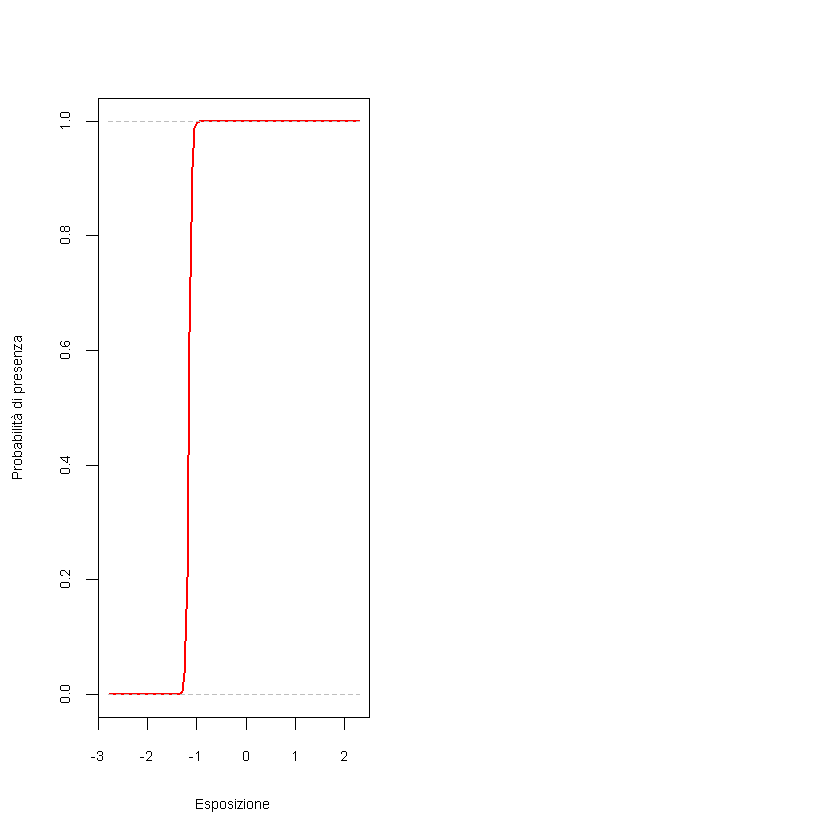

In [24]:
newdat1 <- data.frame(MDR = mean(siteCovs$MDR),
                     Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr), length=100),
                     dominant = "Graminacee")
newdat2 <- data.frame(MDR = mean(siteCovs$MDR),
                      Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr), length=100),
                      dominant = "Muschio")
newdat3 <- data.frame(MDR = mean(siteCovs$MDR),
                      Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr), length=100),
                      dominant = "Other_sp")
newdat <- rbind(newdat1,newdat2,newdat3)
newdat$dominant <- as.numeric(newdat$dominant)
Elambda <- predict(best.mod, type='state', newdata=newdat,
                   appendData=TRUE)
head(Elambda)
Elambda.logit <- Elambda

par(mfrow=c(1, 2))
with(subset(Elambda.logit,dominant=="1"), {
  plot(Esp.tr, Predicted, xlab="Esposizione", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
   lines(Esp.tr, upper, lty=2, col="grey")
  lines(Esp.tr, lower, lty=2, col="grey")
})

,Predicted,SE,lower,upper,MDR,Esp.tr,dominant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,9.527856e-54,9.571364e-100,1,-1.392686,-4.031219e-17,1
2,1,2.784942e-52,4.573528e-97,1,-1.336590,-4.031219e-17,1
3,1,8.134023e-51,2.183053e-94,1,-1.280494,-4.031219e-17,1
4,1,2.373799e-49,1.040811e-91,1,-1.224398,-4.031219e-17,1
5,1,6.921677e-48,4.955962e-89,1,-1.168302,-4.031219e-17,1
6,1,2.016437e-46,2.356577e-86,1,-1.112207,-4.031219e-17,1


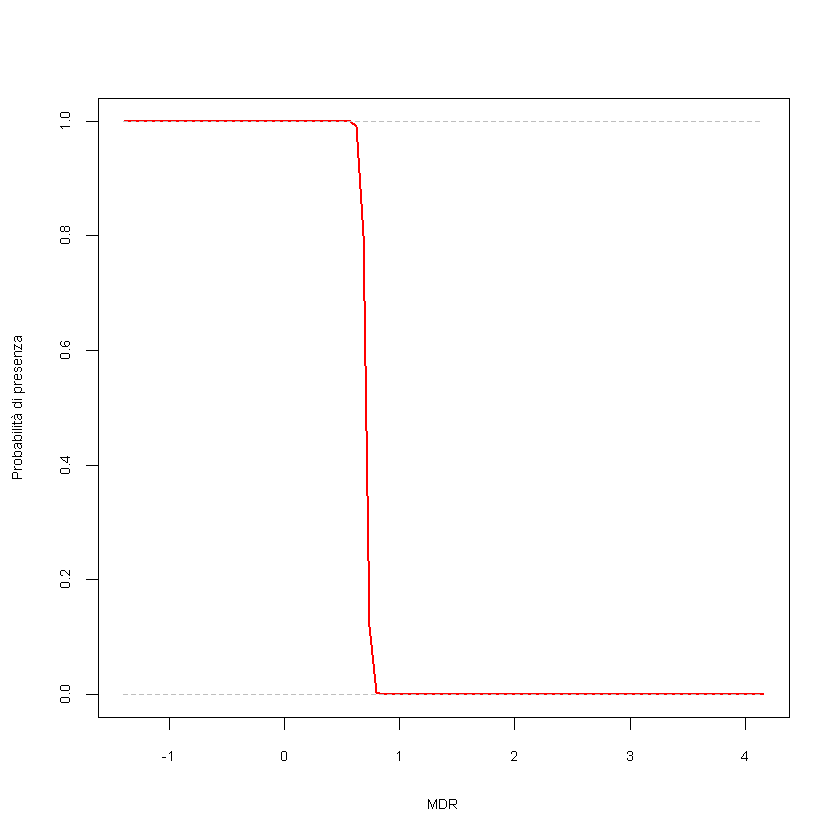

In [25]:
# Predict abundance at specified covariate values.
newdat_1 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      Esp.tr = mean(siteCovs$Esp.tr),
                      dominant = "Graminacee")
newdat_2 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      Esp.tr = mean(siteCovs$Esp.tr),
                      dominant = "Muschio")
newdat_3 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      Esp.tr = mean(siteCovs$Esp.tr),
                      dominant = "Other_sp")
newdata_ <- rbind(newdat_1,newdat_2,newdat_3)
newdata_$dominant <- as.numeric(newdata_$dominant)
Elambda_ <- predict(best.mod, type='state', newdata=newdata_,
                   appendData=TRUE)
head(Elambda_)
Elambda.logit <- Elambda_
with(subset(Elambda.logit,dominant=="1"), {
  plot(MDR, Predicted, xlab="MDR", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(MDR, Predicted+SE, lty=3, col="dark grey")
  # lines(MDR, Predicted-SE, lty=3, col="dark grey")
  lines(MDR, upper, lty=2, col="grey")
  lines(MDR, lower, lty=2, col="grey")
})

In [26]:
#calcolo media temp
maxt <- max(temperatura_occasione[,colonne_oggetto_analisi])
mint <- min(temperatura_occasione[,colonne_oggetto_analisi])
mean(maxt,mint)

[1] 18.9

,Predicted,SE,lower,upper,MDR,temper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.03079619,0.01100703,0.01518921,0.06143897,-1.392686,18.9
2,0.03091220,0.01086058,0.01543175,0.06096044,-1.336590,18.9
3,0.03102862,0.01071804,0.01567293,0.06050444,-1.280494,18.9
4,0.03114547,0.01057972,0.01591230,0.06007151,-1.224398,18.9
5,0.03126275,0.01044597,0.01614938,0.05966224,-1.168302,18.9
6,0.03138046,0.01031712,0.01638367,0.05927726,-1.112207,18.9


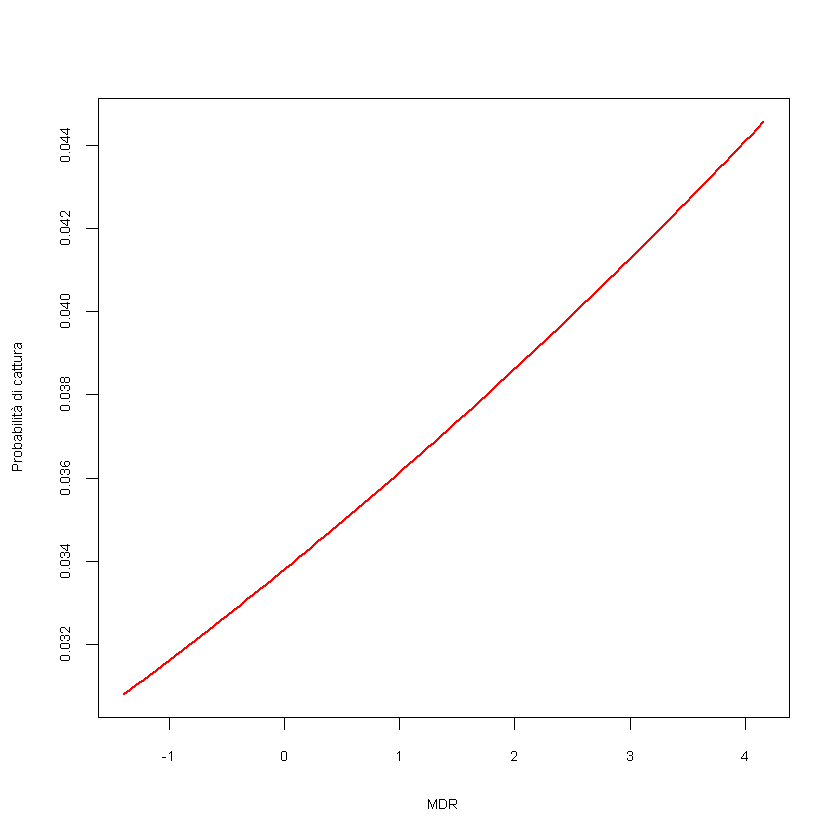

In [27]:
newdata1 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      temper = mean(maxt,mint))
Elambda.det <- predict(best.mod, type='det', newdata=newdata1,
                   appendData=TRUE)
head(Elambda.det)
with(Elambda.det, {
  plot(MDR, Predicted, xlab="MDR", type="l", # names = habitat,
       ylab="Probabilità di cattura", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(MDR, Predicted+SE, lty=3, col="dark grey")
  # lines(MDR, Predicted-SE, lty=3, col="dark grey")
  lines(MDR, upper, lty=2, col="grey")
  lines(MDR, lower, lty=2, col="grey")
})

#### Applichiamo i modelli migliori

In [28]:
best.mod2 <- (get.models(pdd3, 1)[[1]])
best.mod2 


Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + I(IQR^2) + MDR + n_species + I(n_species^2) + slope_degr + 
    I(slope_degr^2) + 1, data = arvicole)

Occupancy:
                Estimate   SE      z P(>|z|)
(Intercept)        -4.42 19.7 -0.224   0.823
cop_veg_ottavi     27.80 21.7  1.279   0.201
dominant          -43.95 31.7 -1.386   0.166
IQR               -10.81 10.9 -0.993   0.321
I(IQR^2)           34.08 21.8  1.564   0.118
MDR               -36.93 23.2 -1.595   0.111
n_species         -25.13 17.7 -1.416   0.157
I(n_species^2)    -39.22 28.4 -1.380   0.168
slope_degr         88.82 62.7  1.416   0.157
I(slope_degr^2)    89.65 58.3  1.539   0.124

Detection:
            Estimate     SE     z  P(>|z|)
(Intercept)   -5.610 1.6725 -3.35 0.000796
orarioTr       1.466 0.3878  3.78 0.000157
temper         0.112 0.0988  1.13 0.258854

AIC: 373.0054 

In [29]:
class(siteCovs$cop_veg_ottavi)
class(siteCovs$n_species)
class(siteCovs$slope_degr)
class(siteCovs$IQR)
class(siteCovs$dominant)

[1] "numeric"

[1] "numeric"

[1] "numeric"

[1] "numeric"

[1] "numeric"

In [30]:
nw_data1 <- data.frame(n_species = mean(siteCovs$n_species),
                     cop_veg_ottavi = seq(min(siteCovs$cop_veg_ottavi, na.rm=TRUE), max(siteCovs$cop_veg_ottavi, na.rm=TRUE), length=100),
                     slope_degr = mean(siteCovs$slope_degr),
                     IQR = seq(min(siteCovs$IQR), max(siteCovs$IQR), length=100),
                     dominant = "Graminacee")
nw_data2 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = seq(min(siteCovs$cop_veg_ottavi, na.rm=TRUE), max(siteCovs$cop_veg_ottavi, na.rm=TRUE), length=100),
                      slope_degr = mean(siteCovs$slope_degr),
                      IQR = seq(min(siteCovs$IQR), max(siteCovs$IQR), length=100),
                      dominant = "Muschio")
nw_data3 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = seq(min(siteCovs$cop_veg_ottavi, na.rm=TRUE), max(siteCovs$cop_veg_ottavi, na.rm=TRUE), length=100),
                      slope_degr = mean(siteCovs$slope_degr),
                      IQR = seq(min(siteCovs$IQR), max(siteCovs$IQR), length=100),
                      dominant = "Other_sp")
w_data <- rbind(nw_data1,nw_data2,nw_data3)
Elmbd <- predict(best.mod2, type='state', newdata=nw_data,
                   appendData=TRUE)

ERROR: Error in .local(object, ...): oggetto "nw_data" non trovato


In [ ]:

par(mfrow=c(1, 3))
with(subset(Elambda.logit,dominante=="Graminacee"), {
  plot(ott, Predicted, xlab="Copertura vegetazionale", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  lines(ott, upper, lty=2, col="grey")
  lines(ott, lower, lty=2, col="grey")
})


In [ ]:
# Predict abundance at specified covariate values.
new_dat1 <- data.frame(n_species = seq(0, 32, length=100),
                      cop_veg_ottavi = 0,
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Graminacee")
new_dat2 <- data.frame(n_species = seq(0, 32, length=100),
                      cop_veg_ottavi = 0,
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Muschio")
new_dat3 <- data.frame(n_species = seq(0, 32, length=100),
                      cop_veg_ottavi = 0,
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Other_sp")
new_dat <- rbind(new_dat1,new_dat2,new_dat3)
elambda <- predict(best.mod, type='state', newdata=new_dat,
                   appendData=TRUE)
head(elambda)
Elambda.logit <- elambda
with(subset(Elambda.logit,dominant=="Graminacee"), {
  plot(n_species, Predicted, xlab="Numero di specie vegetali", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  lines(n_species, upper, lty=2, col="grey")
  lines(n_species, lower, lty=2, col="grey")
})

In [ ]:
# Predict abundance at specified covariate values.
newdati1 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = 0,
                      slope_degr = seq(min(siteCovs$slope_degr),max(siteCovs$slope_degr), lenght=100),
                      dominant = "Graminacee")
newdati2 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = 0,
                      slope_degr = seq(min(siteCovs$slope_degr),max(siteCovs$slope_degr), lenght=100),
                      dominant = "Muschio")
newdati3 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = 0,
                      slope_degr = seq(min(siteCovs$slope_degr),max(siteCovs$slope_degr), lenght=100),
                      dominant = "Other_sp")
newdati_ <- rbind(newdati1,newdati2,newdati3)
elambda_ <- predict(best.mod, type='state', newdata=newdati_,
                   appendData=TRUE)
head(elambda_)
Elambda.logit <- elambda_
with(subset(Elambda.logit,dominant=="Graminacee"), {
  plot(slope_degr, Predicted, xlab="Inclinazione", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
  lines(slope_degr, upper, lty=2, col="grey")
  lines(slope_degr, lower, lty=2, col="grey")
})

